In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mesh_x_count = 4  # количество ячеек по пространству в направлении оси Ox
mesh_y_count = mesh_x_count  # количество ячеек по пространству в направлении оси Oy
mesh_t_count = 5  # количество шагов по времени

In [3]:
dt = 10  # сут, временной шаг
dt *= 24 * 60 * 60  # с, временной шаг

m = 0.18  # пористость

mu = 4  # мПа*с, вязкость жидкости
mu *= 1e-3  # Па*с, вязкость жидкости

k = np.array([
    [30.0, 30.0, 30.0, 30.0],
    [30.0, 40.0, 40.0, 40.0],
    [30.0, 40.0, 40.0, 50.0],
    [30.0, 40.0, 50.0, 40.0]
])  # мД, проницаемость
k *= 1e-3 * (1e-6) ** 2  # м^2, проницаемость

dx = 100  # м, ширина ячейки по оси Ox
dy = 100  # м, ширина ячейки по оси Oy

h = 50  # м, толщина пласта

b_liq = 1  # м^3/м^3, объёмный коэффициент жидкости

compr = 2.2e-9  # Па^(-1), общая сжимаемость

p_initial = 20  # МПа, начальное пластовое давление
p_initial *= 1e6  # Па, начальное пластовое давление

q_inj = 40  # м^3/сут, расход нагнетательной скважины в поверхностных условиях
q_inj /= (24 * 60 * 60)  # м^3/с, расход нагнетательной скважины в поверхностных условиях

q_prod = 40  # м^3/сут, дебит добывающей скважины в поверхностных условиях
q_prod /= (24 * 60 * 60)  # м^3/с, дебит добывающей скважины в поверхностных условиях

In [4]:
# отображать ли матрицы в Jupyter-тетради
display_matrices = True
# настройки отображения чисел в датафрейме
pd.options.display.float_format = '{:.2e}'.format

In [5]:
# матрица проницаемости; заполняем её значениями
k_matrix = np.full((mesh_x_count ** 2, mesh_y_count ** 2), 0.0)
k_matrix += np.diag(k.flatten())

for i in range(mesh_x_count * mesh_y_count):
    if not (i + 1) % mesh_x_count == 0:
        k_matrix[i, i + 1] = 2 * dx / (dx / k[i // mesh_x_count, i % mesh_x_count + 1] + dx / k[i // mesh_x_count, i % mesh_x_count])

for i in range(1, mesh_x_count * mesh_y_count):
    if not i % mesh_x_count == 0:
        k_matrix[i, i - 1] = 2 * dx / (dx / k[i // mesh_x_count, i % mesh_x_count - 1] + dx / k[i // mesh_x_count, i % mesh_x_count])

for i in range(mesh_x_count * mesh_y_count - mesh_x_count):
        k_matrix[i, i + mesh_x_count] = 2 * dx / (dx / k[i // mesh_x_count + 1, i % mesh_x_count] + dx / k[i // mesh_x_count, i % mesh_x_count])

for i in range(mesh_x_count, mesh_x_count * mesh_y_count):
        k_matrix[i, i - mesh_x_count] = 2 * dx / (dx / k[i // mesh_x_count - 1, i % mesh_x_count] + dx / k[i // mesh_x_count, i % mesh_x_count])

if display_matrices:
    print('Матрица проницаемости:')
    df = pd.DataFrame(k_matrix)
    df.index += 1
    df.columns += 1
    for i in range(1, df.shape[0] + 1):
        for j in range(1, df.shape[1] + 1):
            if df.at[i,j] == 0:
                df.loc[i,j] = '0'
    display(df)

Матрица проницаемости:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,3.00e-14,3.00e-14,0,0,3.00e-14,0,0,0,0,0,0,0,0,0,0,0
2,3.00e-14,3.00e-14,3.00e-14,0,0,3.43e-14,0,0,0,0,0,0,0,0,0,0
3,0,3.00e-14,3.00e-14,3.00e-14,0,0,3.43e-14,0,0,0,0,0,0,0,0,0
4,0,0,3.00e-14,3.00e-14,0,0,0,3.43e-14,0,0,0,0,0,0,0,0
5,3.00e-14,0,0,0,3.00e-14,3.43e-14,0,0,3.00e-14,0,0,0,0,0,0,0
6,0,3.43e-14,0,0,3.43e-14,4.00e-14,4.00e-14,0,0,4.00e-14,0,0,0,0,0,0
7,0,0,3.43e-14,0,0,4.00e-14,4.00e-14,4.00e-14,0,0,4.00e-14,0,0,0,0,0
8,0,0,0,3.43e-14,0,0,4.00e-14,4.00e-14,0,0,0,4.44e-14,0,0,0,0
9,0,0,0,0,3.00e-14,0,0,0,3.00e-14,3.43e-14,0,0,3.00e-14,0,0,0
10,0,0,0,0,0,4.00e-14,0,0,3.43e-14,4.00e-14,4.00e-14,0,0,4.00e-14,0,0


In [6]:
# матрица проводимости
trans_matrix = k_matrix / (mu * b_liq * dx**2)
trans_matrix -= np.diag(np.diag(trans_matrix))

if display_matrices:
    print('Матрица проводимости:')
    df = pd.DataFrame(trans_matrix)
    df.index += 1
    df.columns += 1
    for i in range(1, df.shape[0] + 1):
        for j in range(1, df.shape[1] + 1):
            if df.at[i,j] == 0:
                df.loc[i,j] = '0'
    display(df)

Матрица проводимости:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,0,7.50e-16,0,0,7.50e-16,0,0,0,0,0,0,0,0,0,0,0
2,7.50e-16,0,7.50e-16,0,0,8.57e-16,0,0,0,0,0,0,0,0,0,0
3,0,7.50e-16,0,7.50e-16,0,0,8.57e-16,0,0,0,0,0,0,0,0,0
4,0,0,7.50e-16,0,0,0,0,8.57e-16,0,0,0,0,0,0,0,0
5,7.50e-16,0,0,0,0,8.57e-16,0,0,7.50e-16,0,0,0,0,0,0,0
6,0,8.57e-16,0,0,8.57e-16,0,1.00e-15,0,0,1.00e-15,0,0,0,0,0,0
7,0,0,8.57e-16,0,0,1.00e-15,0,1.00e-15,0,0,1.00e-15,0,0,0,0,0
8,0,0,0,8.57e-16,0,0,1.00e-15,0,0,0,0,1.11e-15,0,0,0,0
9,0,0,0,0,7.50e-16,0,0,0,0,8.57e-16,0,0,7.50e-16,0,0,0
10,0,0,0,0,0,1.00e-15,0,0,8.57e-16,0,1.00e-15,0,0,1.00e-15,0,0


In [7]:
# оставшийся множитель перед производной по времени
mult_before_time_derivative = m * compr / dt

final_reservoir_matrix = trans_matrix.copy()

for i in range(mesh_x_count * mesh_y_count):
    final_reservoir_matrix[i, i] = -sum(final_reservoir_matrix[:, i]) - mult_before_time_derivative

if display_matrices:
    print('Матрица СЛАУ:')
    df = pd.DataFrame(final_reservoir_matrix)
    df.index += 1
    df.columns += 1
    for i in range(1, df.shape[0] + 1):
        for j in range(1, df.shape[1] + 1):
            if df.at[i,j] == 0:
                df.loc[i,j] = '0'
    display(df)

Матрица СЛАУ:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,-1.96e-15,7.50e-16,0,0,7.50e-16,0,0,0,0,0,0,0,0,0,0,0
2,7.50e-16,-2.82e-15,7.50e-16,0,0,8.57e-16,0,0,0,0,0,0,0,0,0,0
3,0,7.50e-16,-2.82e-15,7.50e-16,0,0,8.57e-16,0,0,0,0,0,0,0,0,0
4,0,0,7.50e-16,-2.07e-15,0,0,0,8.57e-16,0,0,0,0,0,0,0,0
5,7.50e-16,0,0,0,-2.82e-15,8.57e-16,0,0,7.50e-16,0,0,0,0,0,0,0
6,0,8.57e-16,0,0,8.57e-16,-4.17e-15,1.00e-15,0,0,1.00e-15,0,0,0,0,0,0
7,0,0,8.57e-16,0,0,1.00e-15,-4.32e-15,1.00e-15,0,0,1.00e-15,0,0,0,0,0
8,0,0,0,8.57e-16,0,0,1.00e-15,-3.43e-15,0,0,0,1.11e-15,0,0,0,0
9,0,0,0,0,7.50e-16,0,0,0,-2.82e-15,8.57e-16,0,0,7.50e-16,0,0,0
10,0,0,0,0,0,1.00e-15,0,0,8.57e-16,-4.32e-15,1.00e-15,0,0,1.00e-15,0,0


In [8]:
# список, в который будут добавляться поля давлений на каждом временном шаге
p = []
p.append(np.full((mesh_x_count, mesh_y_count), p_initial))

for time_step in range(mesh_t_count):
    # вектор правых частей
    d = -p[-1].flatten()
    d[3] += q_prod / (dx * dy * h)
    d[12] -= q_inj / (dx * dy * h)
    # решение СЛАУ
    solution = np.matmul(np.linalg.inv(final_reservoir_matrix), d)
    # добавление найденного поля давлений в список
    p.append(solution.reshape(mesh_x_count, mesh_y_count))

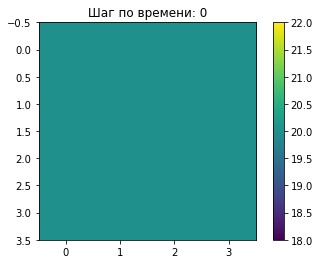

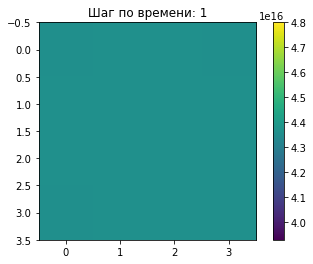

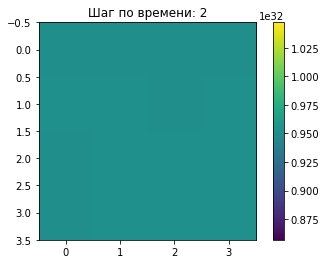

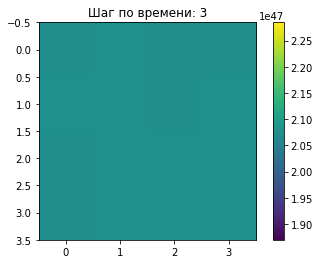

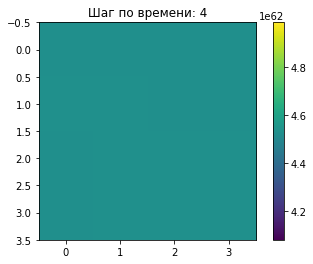

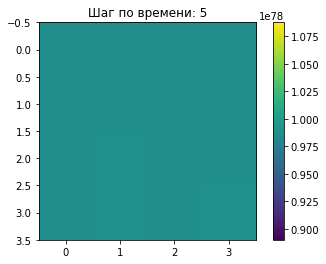

In [9]:
for i, field in enumerate(p):
    plt.figure()
    plt.title(f'Шаг по времени: {i}')
    plt.imshow(field / 1e6)
    plt.colorbar()